## Code to attempt to build the Semeter, Kamalabadi 2005 inversion model in python

written by Riley Troyer fall 2021

In [1]:
# Libraries
from datetime import datetime as dt
import h5py
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad

In [135]:
# Read in the atmospheric density file from MSIS
#msis_filename = 'nrlmsise_20161013_1300ut.txt'
msis_filename = 'nrlmsise_20161013_1030ut.txt'
msis_data = np.loadtxt(msis_filename, skiprows=29)

# Get altitude in km
msis_alt = msis_data[:, 0]
#...convert to meters
msis_alt = msis_alt*1000

# And density in g/cm^-3
msis_density = msis_data[:, 1]
#...convert to kg/m^-3
msis_density = msis_density*1000

# Create a scipy interpolation function to define density v. altitude
msis_interp_density = interp1d(msis_alt, msis_density)

## The first step is to determine a formula for the ion production rate. This depends on the specific atmospheric density.

### $q(z, K) = \frac{\Lambda \rho K F}{35.5 R} $

where K is the energy of an electron in eV. F is the flux, which we'll take to be $1 \times 10^{12} \, \text{m}^{-2} \cdot \text{s}^{-1}$, $R$ is the range-energy function, and $\Lambda$ is a university energy dissipation function.

In [136]:
def barrett_hays_range_energy_func(K):
    """Function to define mass range of electron in air for a specific
    energy K in eV. From Barett & Hays 1976
    INPUT
    K
        type: float
        about: energy of electron in eV
    OUTPUT
    R
        type: float
        about: mass range of particle in kg m^-2 
    """
    # Convert energy to keV to match formula
    K = K/1000
    
    # Range function
    R = 4.3e-7 + 5.36e-6 * K**(1.67) - 0.38e-8 * K**(-0.7)
    
    # Convert R from g/cm^2 to kg/m^2
    R = R * 10
    
    return R

def mass_distance(z, z_inf=1e6, I=0):
    """Function to mass distance of particle traveling some distance
    into the atmosphere. Denoted s in the derivations.
    INPUT
    z
        type: float
        about: altitude that particle reached in meters
    z_inf=1e6
        type: float
        about: altitude that is approximating infinity in meters
    I=0
        type: float
        about: angle of magnetic inclination at measuring site in radians
    OUTPUT
    s
        type: float
        about: mass distance in kg m^-2
    """
    
    # Calculate mass distance traveled 
    s = (1/np.cos(I)) * quad(msis_interp_density, z, z_inf,
                             limit=1000)[0]
    
    return s

In [137]:
# Read in file with energy dissipation function
lambda_filename = 'semeter_kamalabadi_lambda_function.txt'
lambda_data = np.loadtxt(lambda_filename, skiprows=5)

# Create an interpolated function from this
#...values outside set to 0
lambda_interp = interp1d(lambda_data[:, 0], lambda_data[:, 1],
                         bounds_error=False, fill_value=0)

In [138]:
# Define a range of z and K values to define the ion production rate (q)
#...over

# Altitude
altitudes_z = np.linspace(50e3, 140e3, 100)

# Calculate mass distance (s) for each altitude
print('Calculating mass distance function...')
s = np.array([mass_distance(z) for z in altitudes_z])
print('Finished.')

# Get density at each altitude
density_rho = np.array([msis_interp_density(z) for z in altitudes_z])

# Energies
energies_K = np.logspace(np.log10(300), np.log10(300000), 50)

Calculating mass distance function...


/tmp/ipykernel_2514095/1401857884.py:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  s = (1/np.cos(I)) * quad(msis_interp_density, z, z_inf,


Finished.


In [139]:
# Calculate ion production rate for each energy and store in dictionary
ion_prod_rate = {}

for i, energy in enumerate(energies_K):
    
    # Calculate range-energy value
    R = barrett_hays_range_energy_func(energy)
    
    # Get the (s/R)(z) for the energy
    s_R = s/R
    
    # Use s/R to get Lambda function values
    lambda_vals = lambda_interp(s_R)
    
    # Define flux in m^-2 s^-1
    F = 1e12
    
    # Use all of this to calculate ion production rate as function of alt
    q = (lambda_vals * density_rho * energy * F) / (35.5 * R)
    
    # Write to dictionary
    ion_prod_rate[energy] = q

## Now that we have ion production rate as a function of energy and altitude, our next step is to construct the A matrix such that
### $\bf{q} = \bf{A} \phi$
### each column of A is just q(z) for a specific energy multiplied by the energy bin width 

In [140]:
# Construct the A matrix
matrix_A = np.zeros([len(altitudes_z), len(energies_K)])

# Loop through each energy value
for j in range(len(energies_K)):
    
    # Get the size of the energy bin
    #...first bin is from zero to energy
    if j == 0:
        delta_E = energies_K[j] - 0
    else:
        delta_E = energies_K[j] - energies_K[j-1]
        
    # Set column of matrix
    matrix_A[:, j] = ion_prod_rate[energies_K[j]] * (delta_E/F)

## With A created we can now read in the ISR data to get an estimate of $q(z)$, assuming that $q = \alpha n^2 + \frac{dn}{dt}$ and that $\frac{dn}{dt}$ is negligible.

In [141]:
# Get the needed PFISR parameters, altitude, density, time,
#...and temperature

low_cutoff = 0
high_cutoff=1e12

pfisr_filename = '20161013.003_bc_nenotr_1min.h5'

# Read in the h5 file
pfisr_file = h5py.File(pfisr_filename, 'r')

# Get the different beams and select specified angle
beam_angle = 90
beams = np.array(pfisr_file['BeamCodes'])

# Get the beam with a 90 degree beam
indexes = np.linspace(0, len(beams)-1, len(beams))
beam_num = int(indexes[np.abs(beams[:,2] - beam_angle) == 0][0])

# Get time
unix_time = np.array(pfisr_file['Time']['UnixTime'])[:,0]
utc_time = np.array([dt.utcfromtimestamp(d) for d in unix_time])

# Get the altitude array
pfisr_altitude = np.array(pfisr_file['NeFromPower']
                          ['Altitude'])[beam_num, :]

# Convert to kilometers
pfisr_altitude = pfisr_altitude

# Get the uncorrected number density array
e_density = np.array(pfisr_file['NeFromPower']
                     ['Ne_NoTr'])[:, beam_num, :]

# Filter it assuming data outside of range is bad
e_density[e_density < low_cutoff] = 0.0
e_density[e_density > high_cutoff] = 0.0

# Take the transpose
e_density = np.transpose(e_density)

# Get error values
de_density = np.array(pfisr_file['NeFromPower']
                      ['errNe_NoTr'])[:, beam_num, :]
de_density = np.transpose(de_density)

# Close file
pfisr_file.close()

## For testing purposes I'm only going to consider 1 slice of data

In [144]:
# slice number
#n = 150
#n = 145
#n = 50
n = 2
e_density_slice = e_density[:, n]
de_density_slice = de_density[:, n]

# Only take value above 50 km, below data can be off
e_density_slice = e_density_slice[pfisr_altitude > 50]

de_density_slice = de_density_slice[pfisr_altitude>50]


# Make an interpolation model of this data with respect to altitude
#...but only do this for altitudes >50 km, below data can be weird
pfisr_density_interp = interp1d(pfisr_altitude[pfisr_altitude>50],
                                e_density_slice[pfisr_altitude>50])

pfisr_error_interp = interp1d(pfisr_altitude[pfisr_altitude>50],
                              de_density_slice[pfisr_altitude>50])

In [145]:
def recombination_coeff(z):
    """Function defining recombination coefficient
    INPUT
    z
        type:float
        about: altitude in kilometers
    OUTPUT
    alpha
        type: float
        about: recombination coefficient in m^3/s
    """
    
    alpha = 2.5e-12 * np.exp(-z/51.2)
    
    return alpha

In [146]:
# Calculate all recombination coeffcients
alphas = np.array([recombination_coeff(z/1000) for z in altitudes_z])

# Multiply by pfisr density to get an estimate of ion production rate
q_estimate = alphas * pfisr_density_interp(altitudes_z)**2

# Get error dq = 2*alpha*n*dn
dq_estimate = (2 * alphas * pfisr_density_interp(altitudes_z)
               * pfisr_error_interp(altitudes_z))

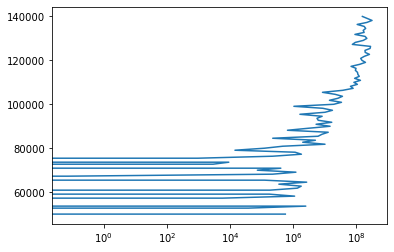

In [147]:
plt.plot(q_estimate, altitudes_z)
plt.xscale('log')

In [148]:
# Make an initial guess of the number flux
initial_num_flux = np.ones(len(energies_K))*(1e12/len(energies_K))

# Divide by energy bin widths
bin_widths = energies_K - np.roll(energies_K, shift=1)

# Fix first value
bin_widths[0] = energies_K[0] - 0

# Set initial guess
initial_num_flux = initial_num_flux/bin_widths

# If full column of A matrix is zero set initial flux to zero
for j in range(len(energies_K)):
    
    if np.sum(matrix_A[:, j]) == 0:
        initial_num_flux[j] = 0

In [149]:
# Set previous value to initial at start
old_num_flux = initial_num_flux
new_num_flux = np.zeros(len(initial_num_flux))

# Create array to store all minimum j values
min_js = np.zeros(len(altitudes_z), dtype=int)

# Find all nonzero indices of A matrix
nonzero_args = np.argwhere(matrix_A > 0)

for i in range(len(min_js)):

    non_zeros = nonzero_args[nonzero_args[:, 0] == i]

    # If there are no non zero values in row, then set to first instance
    if len(non_zeros) == 0:
        min_js[i] = 0

    # Otherwise find the minimum j
    else:
        min_js[i] = min(non_zeros[:, 1])
        
# Find the index past which A is defined for altitudes
good_alt_index = np.argwhere(min_js>0)[0][0]

# Run interations until chi2 < 1.5
reduced_chi_square = 10

# Or count < specified amount
count = 0

while (reduced_chi_square > 1.5):    

    # Check count
    if count > 10000:
        print('Max iterations reached with chi2 = ', reduced_chi_square)
        break
    
    # Construct the t vector
    t = 1/np.dot(matrix_A[:, min_js], old_num_flux[min_js])

    # Adjust for infinite values in regions without a nonzero j
    t[t == np.inf] = 0        

    for j in range(len(energies_K)):

        # Construct c vector
        frac = np.inner(matrix_A, old_num_flux)/q_estimate
        c = 20 * (1 - frac) * t

        # Account for nan and infinite values
        #...this is why warning is raised
        c[np.isnan(c)] = 0
        c[c == -np.inf] = 0
        c[c == np.inf] = 0

        # Define w constant
        w = np.ones(len(altitudes_z))/len(altitudes_z)

        # Summation of matrix elements
        i_sum = np.sum(w*c*matrix_A[:, j])

        # New guess
        new_num_flux[j] = old_num_flux[j]/(1 - old_num_flux[j] * i_sum)

    # Check chi squared, but only on altitudes that A is defined for
    diff = q_estimate - np.dot(matrix_A, new_num_flux)
    chi_square_array = diff**2/dq_estimate**2
    
    # Set undefined values to zero
    chi_square_array[np.isnan(chi_square_array)] = 0
    chi_square_array[chi_square_array == np.inf] = 0
    chi_square_array[chi_square_array == -np.inf] = 0
    
    chi_square = np.sum(chi_square_array)
    
    # Reduced chi square should be around 1
    reduced_chi_square = chi_square/(len(diff[good_alt_index:])-1)

    # Set old value to new
    old_num_flux = np.copy(new_num_flux)
    
    # Set count
    count = count + 1
    
print('Convergence reached. Iterations: ', count-1)

Convergence reached. Iterations:  2


/tmp/ipykernel_2514095/3906768603.py:40: RuntimeWarning: divide by zero encountered in true_divide
  t = 1/np.dot(matrix_A[:, min_js], old_num_flux[min_js])
/tmp/ipykernel_2514095/3906768603.py:48: RuntimeWarning: divide by zero encountered in true_divide
  frac = np.inner(matrix_A, old_num_flux)/q_estimate
/tmp/ipykernel_2514095/3906768603.py:48: RuntimeWarning: invalid value encountered in true_divide
  frac = np.inner(matrix_A, old_num_flux)/q_estimate
/tmp/ipykernel_2514095/3906768603.py:68: RuntimeWarning: divide by zero encountered in true_divide
  chi_square_array = diff**2/dq_estimate**2
/tmp/ipykernel_2514095/3906768603.py:68: RuntimeWarning: invalid value encountered in true_divide
  chi_square_array = diff**2/dq_estimate**2


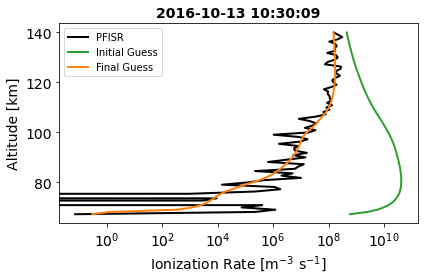

In [150]:
# Plot figure of initial guess, real data and fit
fig, ax = plt.subplots()

# Titles and axis labels
ax.set_title(str(utc_time[n]),
             fontsize=14, fontweight='bold')

ax.set_ylabel('Altitude [km]', fontsize=14)
ax.set_xlabel(r'Ionization Rate [m$^{-3}$ s$^{-1}$]', fontsize=14)

# Axis
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.set_xscale('log')

# Plot PFISR data
ax.plot(q_estimate[good_alt_index:],
        altitudes_z[good_alt_index:]/1000,
        color='k', linewidth=2, label = 'PFISR')

# Plot initial guess
ax.plot(np.dot(matrix_A, initial_num_flux)[good_alt_index:],
        altitudes_z[good_alt_index:]/1000,
        color='C2', linewidth=2, label = 'Initial Guess')

# Plot final guess
ax.plot(np.dot(matrix_A, new_num_flux)[good_alt_index:],
        altitudes_z[good_alt_index:]/1000,
        color='C1', linewidth=2, label = 'Final Guess')

plt.legend()

plt.tight_layout()

plt.savefig('semeter-inversion-test-q-2.jpg', dpi=150)

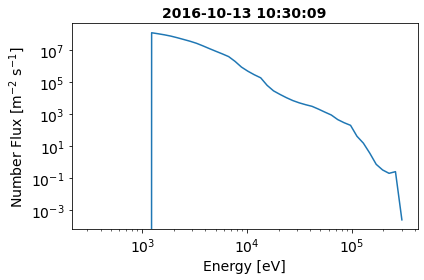

In [151]:
# Plot figure of initial guess, real data and fit
fig, ax = plt.subplots()

# Titles and axis labels
ax.set_title(str(utc_time[n]),
             fontsize=14, fontweight='bold')

ax.set_ylabel(r'Number Flux [m$^{-2}$ s$^{-1}$]', fontsize=14)
ax.set_xlabel('Energy [eV]', fontsize=14)

# Axis
ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.set_xscale('log')
ax.set_yscale('log')

# Plot the energy
ax.plot(energies_K, new_num_flux)

plt.tight_layout()

plt.savefig('semeter-inversion-test-numflux-2.jpg', dpi=150)